In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
import time
import sklearn
import numpy as np
import pandas as pd
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold


In [2]:
start = time.time()
methy_glioma = pd.read_csv('data_methylation_G.csv')
methy_glioma_update = methy_glioma.rename(columns={"Unnamed: 0": "attrib_name"})


train_clinical73_G = pd.read_csv('train_clinical_G73_merged.csv')
train_clinical73_G = train_clinical73_G.rename(columns={"Unnamed: 0.1": "attrib_name"})

test_clinical73_G = pd.read_csv('test_clinical_G73_merged.csv')
test_clinical73_G = test_clinical73_G.rename(columns={"Unnamed: 0.1": "attrib_name"})
print(train_clinical73_G.shape)
print(test_clinical73_G.shape)

train_clinical82_G = pd.read_csv('train_clinical_G82_merged.csv')
train_clinical82_G = train_clinical82_G.rename(columns={"Unnamed: 0.1": "attrib_name"})

test_clinical82_G = pd.read_csv('test_clinical_G82_merged.csv')
test_clinical82_G = test_clinical82_G.rename(columns={"Unnamed: 0.1": "attrib_name"})
print(train_clinical82_G.shape)
print(test_clinical82_G.shape)


end = time.time()

exec_time = end - start
print("data loading time: ", exec_time)

(355, 11)
(153, 11)
(406, 11)
(102, 11)
data loading time:  773.1293892860413


In [8]:
# receive the index so that we can match each techs
train_idx_82G = train_clinical82_G[['attrib_name']]
test_idx_82G = test_clinical82_G[['attrib_name']]

train_idx_73G = train_clinical73_G[['attrib_name']]
test_idx_73G = test_clinical73_G[['attrib_name']]

In [5]:
train_idx_82G

,attrib_name
0,TCGA.DU.A7TI
1,TCGA.P5.A5EU
2,TCGA.TM.A84T
3,TCGA.S9.A7QZ
4,TCGA.HT.8015
...,...
401,TCGA.DU.7007
402,TCGA.TQ.A7RM
403,TCGA.HT.A61C
404,TCGA.QH.A6CZ


## Models and Support Functions

In [14]:
# Build up autoencoder model
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(embed_dim, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 512),
            nn.ReLU(True),
            nn.Linear(512, 256)
        )
        self.decoder = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, embed_dim),
            nn.Tanh()
        )
        
    def forward(self, x):
        latent = self.encoder(x)
        output = self.decoder(latent)
        return output

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(123)

#train_torch = torch.FloatTensor(train_scaled)
#test_torch = torch.FloatTensor(test_scaled)

criterion = nn.MSELoss()

k = 10
batch_size = 128
epochs = 10
lr = 0.001

kfold = KFold(n_splits=10, random_state=123, shuffle=True)


In [16]:
#define train function and validation function
def train_epoch(model, device, optimizer, loss_func, dataloader):
    model.train()
    train_loss = 0.0
    
    for features in dataloader:
        features = features.to(device)
        optimizer.zero_grad()
        output = model(features)
        loss = loss_func(output, features)
    
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss = train_loss/len(dataloader)

    return train_loss
  
def validation_epoch(model, device, loss_func, dataloader):
    model.eval()
    valid_loss = 0.0

    for features in dataloader:
        features = features.to(device)
        output = model(features)
        loss = loss_func(output, features)

        valid_loss += loss.item()
        
    valid_loss = valid_loss/len(dataloader)

    return valid_loss

## Load Glioma 7:3 splits

In [6]:
train_glioma_73G = methy_glioma_update.merge(train_idx_73G, on='attrib_name', how="inner")
test_glioma_73G = methy_glioma_update.merge(test_idx_73G, on='attrib_name', how="inner")



print(methy_glioma_update.shape)
print(train_glioma_73G.shape)
print(test_glioma_73G.shape)

(508, 336631)
(355, 336631)
(153, 336631)


In [7]:
# fill empty value with mean of each column

print(train_glioma_73G.isna().sum())
train_glioma_73G = train_glioma_73G.fillna(train_glioma_73G.mean())
print(train_glioma_73G.isna().sum())
print("---------------------------------")
print(test_glioma_73G.isna().sum())
test_glioma_73G= test_glioma_73G.fillna(test_glioma_73G.mean())
print(test_glioma_73G.isna().sum())


attrib_name              0
RBL2_cg00000029          0
VDAC3_cg00000236         0
ACTN1_cg00000289         0
ATP2A1_cg00000292        0
                        ..
SNORD66_ch.3.3596501R    2
FAM13B_ch.5.2533205R     2
PKD2L2_ch.5.2533205R     2
HNRNPK_ch.9.1116984R     6
MIR7-1_ch.9.1116984R     6
Length: 336631, dtype: int64
attrib_name              0
RBL2_cg00000029          0
VDAC3_cg00000236         0
ACTN1_cg00000289         0
ATP2A1_cg00000292        0
                        ..
SNORD66_ch.3.3596501R    0
FAM13B_ch.5.2533205R     0
PKD2L2_ch.5.2533205R     0
HNRNPK_ch.9.1116984R     0
MIR7-1_ch.9.1116984R     0
Length: 336631, dtype: int64
---------------------------------
attrib_name              0
RBL2_cg00000029          0
VDAC3_cg00000236         0
ACTN1_cg00000289         0
ATP2A1_cg00000292        0
                        ..
SNORD66_ch.3.3596501R    4
FAM13B_ch.5.2533205R     4
PKD2L2_ch.5.2533205R     4
HNRNPK_ch.9.1116984R     4
MIR7-1_ch.9.1116984R     4
Length: 336631, d

In [11]:
train_glioma_73G

,attrib_name,RBL2_cg00000029,VDAC3_cg00000236,ACTN1_cg00000289,ATP2A1_cg00000292,SFRP1_cg00000321,NIPA2_cg00000622,MAN1B1_cg00000658,TSEN34_cg00000714,LRRC16A_cg00000721,...,SNORD67_ch.11.967412F,CKAP5_ch.11.967412F,TRIM13_ch.13.693633F,DLEU2_ch.13.693633F,EIF4G1_ch.3.3596501R,SNORD66_ch.3.3596501R,FAM13B_ch.5.2533205R,PKD2L2_ch.5.2533205R,HNRNPK_ch.9.1116984R,MIR7-1_ch.9.1116984R
0,TCGA.CS.4941,0.1547,0.4064,0.0946,-0.0715,0.1731,-0.4874,0.3125,-0.3610,0.4414,...,-0.4678,-0.4678,-0.4658,-0.4658,-0.3910,-0.3910,-0.3996,-0.3996,-0.3849,-0.3849
1,TCGA.CS.4942,0.3262,0.4331,0.1420,0.3801,0.2429,-0.4847,0.3318,-0.3620,0.4512,...,-0.4697,-0.4697,-0.4713,-0.4713,-0.4323,-0.4323,-0.3919,-0.3919,-0.4010,-0.4010
2,TCGA.CS.4943,0.3769,0.4310,0.2770,0.4431,0.2917,-0.4848,0.3020,-0.3182,0.4361,...,-0.4750,-0.4750,-0.4671,-0.4671,-0.4114,-0.4114,-0.4188,-0.4188,-0.4249,-0.4249
3,TCGA.CS.4944,0.3774,0.4343,0.1074,0.4082,0.2243,-0.4892,0.3381,-0.3363,0.4512,...,-0.4640,-0.4640,-0.4643,-0.4643,-0.3798,-0.3798,-0.3934,-0.3934,-0.4054,-0.4054
4,TCGA.CS.5393,0.2906,0.4170,0.2457,0.3321,0.2646,-0.4860,0.3497,-0.4098,0.4549,...,-0.4677,-0.4677,-0.4716,-0.4716,-0.4189,-0.4189,-0.4158,-0.4158,-0.4188,-0.4188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350,TCGA.WY.A858,0.1727,0.4153,0.1237,0.3291,0.0240,-0.4891,0.3894,-0.3960,0.4133,...,-0.4703,-0.4703,-0.4632,-0.4632,-0.4358,-0.4358,-0.4322,-0.4322,-0.3889,-0.3889
351,TCGA.WY.A85A,0.3761,0.4039,0.1768,0.3840,0.2643,-0.4849,0.3293,-0.3757,0.4468,...,-0.4660,-0.4660,-0.4609,-0.4609,-0.3971,-0.3971,-0.3779,-0.3779,-0.3386,-0.3386
352,TCGA.WY.A85B,0.3002,0.4244,0.1748,0.4003,0.3041,-0.4883,0.3578,-0.3155,0.4441,...,-0.4620,-0.4620,-0.4601,-0.4601,-0.3834,-0.3834,-0.3397,-0.3397,-0.3172,-0.3172
353,TCGA.WY.A85C,0.3287,0.4228,0.1911,0.4142,0.3145,-0.4855,0.3114,-0.4267,0.4189,...,-0.4727,-0.4727,-0.4682,-0.4682,-0.3948,-0.3948,-0.3498,-0.3498,-0.2759,-0.2759


In [10]:
test_glioma_73G

,attrib_name,RBL2_cg00000029,VDAC3_cg00000236,ACTN1_cg00000289,ATP2A1_cg00000292,SFRP1_cg00000321,NIPA2_cg00000622,MAN1B1_cg00000658,TSEN34_cg00000714,LRRC16A_cg00000721,...,SNORD67_ch.11.967412F,CKAP5_ch.11.967412F,TRIM13_ch.13.693633F,DLEU2_ch.13.693633F,EIF4G1_ch.3.3596501R,SNORD66_ch.3.3596501R,FAM13B_ch.5.2533205R,PKD2L2_ch.5.2533205R,HNRNPK_ch.9.1116984R,MIR7-1_ch.9.1116984R
0,TCGA.CS.4938,0.3476,0.4037,0.0746,0.4135,0.2783,-0.4808,0.4188,-0.3673,0.4422,...,-0.4707,-0.4707,-0.4509,-0.4509,-0.379206,-0.379206,-0.4038,-0.4038,-0.3946,-0.3946
1,TCGA.CS.5390,0.3776,0.4205,0.3456,0.3734,0.2859,-0.4866,0.3081,-0.3606,0.4561,...,-0.4770,-0.4770,-0.4681,-0.4681,-0.439900,-0.439900,-0.4090,-0.4090,-0.4334,-0.4334
2,TCGA.CS.5396,0.3613,0.3147,0.3332,0.2063,0.2534,-0.4850,0.3300,-0.3911,0.4555,...,-0.4805,-0.4805,-0.4650,-0.4650,-0.422700,-0.422700,-0.4174,-0.4174,-0.4461,-0.4461
3,TCGA.CS.6186,0.2496,0.4365,0.2588,0.0187,0.3581,-0.4874,0.3787,-0.4244,0.4639,...,-0.4747,-0.4747,-0.4674,-0.4674,-0.414400,-0.414400,-0.4055,-0.4055,-0.4238,-0.4238
4,TCGA.CS.6290,0.2531,0.4079,0.1823,0.3442,0.0315,-0.4851,0.3613,-0.4041,0.4385,...,-0.4720,-0.4720,-0.4667,-0.4667,-0.303800,-0.303800,-0.3842,-0.3842,-0.3654,-0.3654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,TCGA.VM.A8C9,0.0147,0.4093,0.2324,-0.0010,0.1187,-0.4909,0.3669,-0.4244,0.4096,...,-0.4671,-0.4671,-0.4626,-0.4626,-0.394600,-0.394600,-0.4254,-0.4254,-0.3284,-0.3284
149,TCGA.VV.A86M,0.3702,0.4188,0.2155,0.3931,0.3523,-0.4867,0.3530,-0.3938,0.4516,...,-0.4619,-0.4619,-0.4619,-0.4619,-0.424100,-0.424100,-0.3782,-0.3782,-0.3440,-0.3440
150,TCGA.VW.A7QS,0.2510,0.2820,0.0874,0.3618,0.3851,-0.4873,0.2933,-0.3677,0.4385,...,-0.4528,-0.4528,-0.4442,-0.4442,-0.305700,-0.305700,-0.3355,-0.3355,-0.3045,-0.3045
151,TCGA.WY.A859,0.3172,0.4129,0.2609,0.3364,0.3074,-0.4877,0.3328,-0.3791,0.4344,...,-0.4582,-0.4582,-0.4662,-0.4662,-0.426800,-0.426800,-0.3347,-0.3347,-0.2894,-0.2894


In [18]:
train_glioma_73G

,attrib_name,RBL2_cg00000029,VDAC3_cg00000236,ACTN1_cg00000289,ATP2A1_cg00000292,SFRP1_cg00000321,NIPA2_cg00000622,MAN1B1_cg00000658,TSEN34_cg00000714,LRRC16A_cg00000721,...,SNORD67_ch.11.967412F,CKAP5_ch.11.967412F,TRIM13_ch.13.693633F,DLEU2_ch.13.693633F,EIF4G1_ch.3.3596501R,SNORD66_ch.3.3596501R,FAM13B_ch.5.2533205R,PKD2L2_ch.5.2533205R,HNRNPK_ch.9.1116984R,MIR7-1_ch.9.1116984R
0,TCGA.CS.4941,0.1547,0.4064,0.0946,-0.0715,0.1731,-0.4874,0.3125,-0.3610,0.4414,...,-0.4678,-0.4678,-0.4658,-0.4658,-0.3910,-0.3910,-0.3996,-0.3996,-0.3849,-0.3849
1,TCGA.CS.4942,0.3262,0.4331,0.1420,0.3801,0.2429,-0.4847,0.3318,-0.3620,0.4512,...,-0.4697,-0.4697,-0.4713,-0.4713,-0.4323,-0.4323,-0.3919,-0.3919,-0.4010,-0.4010
2,TCGA.CS.4943,0.3769,0.4310,0.2770,0.4431,0.2917,-0.4848,0.3020,-0.3182,0.4361,...,-0.4750,-0.4750,-0.4671,-0.4671,-0.4114,-0.4114,-0.4188,-0.4188,-0.4249,-0.4249
3,TCGA.CS.4944,0.3774,0.4343,0.1074,0.4082,0.2243,-0.4892,0.3381,-0.3363,0.4512,...,-0.4640,-0.4640,-0.4643,-0.4643,-0.3798,-0.3798,-0.3934,-0.3934,-0.4054,-0.4054
4,TCGA.CS.5393,0.2906,0.4170,0.2457,0.3321,0.2646,-0.4860,0.3497,-0.4098,0.4549,...,-0.4677,-0.4677,-0.4716,-0.4716,-0.4189,-0.4189,-0.4158,-0.4158,-0.4188,-0.4188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350,TCGA.WY.A858,0.1727,0.4153,0.1237,0.3291,0.0240,-0.4891,0.3894,-0.3960,0.4133,...,-0.4703,-0.4703,-0.4632,-0.4632,-0.4358,-0.4358,-0.4322,-0.4322,-0.3889,-0.3889
351,TCGA.WY.A85A,0.3761,0.4039,0.1768,0.3840,0.2643,-0.4849,0.3293,-0.3757,0.4468,...,-0.4660,-0.4660,-0.4609,-0.4609,-0.3971,-0.3971,-0.3779,-0.3779,-0.3386,-0.3386
352,TCGA.WY.A85B,0.3002,0.4244,0.1748,0.4003,0.3041,-0.4883,0.3578,-0.3155,0.4441,...,-0.4620,-0.4620,-0.4601,-0.4601,-0.3834,-0.3834,-0.3397,-0.3397,-0.3172,-0.3172
353,TCGA.WY.A85C,0.3287,0.4228,0.1911,0.4142,0.3145,-0.4855,0.3114,-0.4267,0.4189,...,-0.4727,-0.4727,-0.4682,-0.4682,-0.3948,-0.3948,-0.3498,-0.3498,-0.2759,-0.2759


In [19]:
test_glioma_73G

,attrib_name,RBL2_cg00000029,VDAC3_cg00000236,ACTN1_cg00000289,ATP2A1_cg00000292,SFRP1_cg00000321,NIPA2_cg00000622,MAN1B1_cg00000658,TSEN34_cg00000714,LRRC16A_cg00000721,...,SNORD67_ch.11.967412F,CKAP5_ch.11.967412F,TRIM13_ch.13.693633F,DLEU2_ch.13.693633F,EIF4G1_ch.3.3596501R,SNORD66_ch.3.3596501R,FAM13B_ch.5.2533205R,PKD2L2_ch.5.2533205R,HNRNPK_ch.9.1116984R,MIR7-1_ch.9.1116984R
0,TCGA.CS.4938,0.3476,0.4037,0.0746,0.4135,0.2783,-0.4808,0.4188,-0.3673,0.4422,...,-0.4707,-0.4707,-0.4509,-0.4509,-0.379206,-0.379206,-0.4038,-0.4038,-0.3946,-0.3946
1,TCGA.CS.5390,0.3776,0.4205,0.3456,0.3734,0.2859,-0.4866,0.3081,-0.3606,0.4561,...,-0.4770,-0.4770,-0.4681,-0.4681,-0.439900,-0.439900,-0.4090,-0.4090,-0.4334,-0.4334
2,TCGA.CS.5396,0.3613,0.3147,0.3332,0.2063,0.2534,-0.4850,0.3300,-0.3911,0.4555,...,-0.4805,-0.4805,-0.4650,-0.4650,-0.422700,-0.422700,-0.4174,-0.4174,-0.4461,-0.4461
3,TCGA.CS.6186,0.2496,0.4365,0.2588,0.0187,0.3581,-0.4874,0.3787,-0.4244,0.4639,...,-0.4747,-0.4747,-0.4674,-0.4674,-0.414400,-0.414400,-0.4055,-0.4055,-0.4238,-0.4238
4,TCGA.CS.6290,0.2531,0.4079,0.1823,0.3442,0.0315,-0.4851,0.3613,-0.4041,0.4385,...,-0.4720,-0.4720,-0.4667,-0.4667,-0.303800,-0.303800,-0.3842,-0.3842,-0.3654,-0.3654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
148,TCGA.VM.A8C9,0.0147,0.4093,0.2324,-0.0010,0.1187,-0.4909,0.3669,-0.4244,0.4096,...,-0.4671,-0.4671,-0.4626,-0.4626,-0.394600,-0.394600,-0.4254,-0.4254,-0.3284,-0.3284
149,TCGA.VV.A86M,0.3702,0.4188,0.2155,0.3931,0.3523,-0.4867,0.3530,-0.3938,0.4516,...,-0.4619,-0.4619,-0.4619,-0.4619,-0.424100,-0.424100,-0.3782,-0.3782,-0.3440,-0.3440
150,TCGA.VW.A7QS,0.2510,0.2820,0.0874,0.3618,0.3851,-0.4873,0.2933,-0.3677,0.4385,...,-0.4528,-0.4528,-0.4442,-0.4442,-0.305700,-0.305700,-0.3355,-0.3355,-0.3045,-0.3045
151,TCGA.WY.A859,0.3172,0.4129,0.2609,0.3364,0.3074,-0.4877,0.3328,-0.3791,0.4344,...,-0.4582,-0.4582,-0.4662,-0.4662,-0.426800,-0.426800,-0.3347,-0.3347,-0.2894,-0.2894


In [ ]:
train_glioma_73 = train_glioma_73G.iloc[:, 1:]
test_glioma_73 = test_glioma_73G.iloc[:, 1:]
print(train_glioma_73.shape)
print(test_glioma_73.shape)
train_glioma73_numpy = train_glioma_73.to_numpy()
test_glioma73_numpy = test_glioma_73.to_numpy()

scaler_glioma73 = MinMaxScaler()
train_glioma73_scaled = scaler_glioma73.fit_transform(train_glioma73_numpy)
test_glioma73_scaled = scaler_glioma73.transform(test_glioma73_numpy)

In [ ]:
# convert to tensor type
train_glioma73_torch = torch.FloatTensor(train_glioma73_scaled)
test_glioma73_torch = torch.FloatTensor(test_glioma73_scaled)

In [ ]:
#save the attrib_name
train_glioma73_name = train_glioma_73G.iloc[:, 0]
test_glioma73_name = test_glioma_73G.iloc[:, 0]
print(train_glioma73_name)
print(test_glioma73_name)

train_glioma73_name.to_csv("train_73G_idx.csv")
test_glioma73_name.to_csv("test_73G_idx.csv")

### Glioma 7:3 training and output

In [20]:
# 10 fold cross validation
train_fold_loss = []
valid_fold_loss = []
embed_dim = train_glioma73_torch.shape[1]

# assign train_torch and test_torch
train_torch = train_glioma73_torch
test_torch = test_glioma73_torch

for k, (train_idx,valid_idx) in enumerate(kfold.split(np.arange(len(train_torch)))):
    
    print('Fold: ', k+1 )
    train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
    valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
      train_torch, batch_size=batch_size, sampler=train_sampler
  )
    valid_loader = torch.utils.data.DataLoader(
      train_torch, batch_size=batch_size, sampler=valid_sampler
  )

    model = autoencoder().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        train_loss = train_epoch(model, device, optimizer, criterion, train_loader)
        valid_loss = validation_epoch(model, device, criterion, valid_loader)

        print('epoch [{}/{}], train_loss:{:.4f}, valid_loss:{:.4f}'
          .format(epoch + 1, epochs, train_loss, valid_loss))
    
    train_fold_loss.append(train_loss)
    valid_fold_loss.append(valid_loss)

Fold:  1
epoch [1/10], train_loss:0.6205, valid_loss:0.4502
epoch [2/10], train_loss:0.3106, valid_loss:0.1440
epoch [3/10], train_loss:0.1041, valid_loss:0.0603
epoch [4/10], train_loss:0.0563, valid_loss:0.0556
epoch [5/10], train_loss:0.0428, valid_loss:0.0388
epoch [6/10], train_loss:0.0329, valid_loss:0.0337
epoch [7/10], train_loss:0.0300, valid_loss:0.0320
epoch [8/10], train_loss:0.0279, valid_loss:0.0313
epoch [9/10], train_loss:0.0276, valid_loss:0.0291
epoch [10/10], train_loss:0.0259, valid_loss:0.0273
Fold:  2
epoch [1/10], train_loss:0.5956, valid_loss:0.3764
epoch [2/10], train_loss:0.2658, valid_loss:0.1112
epoch [3/10], train_loss:0.0939, valid_loss:0.0587
epoch [4/10], train_loss:0.0476, valid_loss:0.0368
epoch [5/10], train_loss:0.0339, valid_loss:0.0337
epoch [6/10], train_loss:0.0310, valid_loss:0.0299
epoch [7/10], train_loss:0.0277, valid_loss:0.0282
epoch [8/10], train_loss:0.0262, valid_loss:0.0282
epoch [9/10], train_loss:0.0267, valid_loss:0.0270
epoch [10/10

In [ ]:
#draw diagram for 10 fold loss comparison

In [21]:
# formal training
embed_dim = train_glioma73_torch.shape[1]

train_glioma73_loader = torch.utils.data.DataLoader(
      train_glioma73_torch, batch_size=batch_size, shuffle=True
  )
test_glioma73_loader = torch.utils.data.DataLoader(
      test_glioma73_torch, batch_size=batch_size, shuffle=False
  )

model_methy_73G = autoencoder().to(device)
optimizer = optim.Adam(model_methy_73G.parameters(), lr=lr)

for epoch in range(epochs):
    train_loss = train_epoch(model_methy_73G, device, optimizer, criterion, train_glioma73_loader)

    print('epoch [{}/{}], train_loss:{:.4f}'
        .format(epoch + 1, epochs, train_loss))

epoch [1/10], train_loss:0.6283
epoch [2/10], train_loss:0.3422
epoch [3/10], train_loss:0.1284
epoch [4/10], train_loss:0.0561
epoch [5/10], train_loss:0.0399
epoch [6/10], train_loss:0.0329
epoch [7/10], train_loss:0.0299
epoch [8/10], train_loss:0.0280
epoch [9/10], train_loss:0.0264
epoch [10/10], train_loss:0.0257


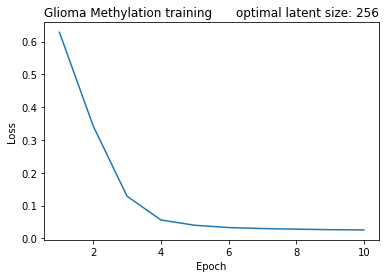

In [8]:
import matplotlib.pyplot as plt
plt.title("Glioma Methylation training", loc="left")
plt.title("optimal latent size: 256", loc="right")
plt.xlabel("Epoch")
plt.ylabel("Loss")
loss = [0.6283, 0.3422, 0.1284, 0.0561, 0.0399, 0.0329, 0.0299, 0.0280, 0.0264, 0.0257]
plt.plot(range(1,11), loss)

In [22]:
# save and load the model
torch.save(model_methy_73G, "methy_73G.pt")

methy_73G = torch.load("methy_73G.pt")
methy_73G

C:\conda\lib\site-packages\torch\serialization.py:359: UserWarning: Couldn't retrieve source code for container of type autoencoder. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "


autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=336630, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=512, out_features=256, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=1024, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=1024, out_features=336630, bias=True)
    (5): Tanh()
  )
)

In [23]:
# for train data only
methy_Tr73G_output = methy_73G.encoder(train_glioma73_torch)
print(methy_Tr73G_output.shape)
print(methy_Tr73G_output)
methy_Tr73G_output = methy_Tr73G_output.cpu().detach().numpy()
np.savetxt('methy_Tr73G.csv', methy_Tr73G_output, delimiter=',')

torch.Size([355, 256])
tensor([[-1.6063, -1.4736, -1.2486,  ...,  1.7321,  1.4525,  4.1934],
        [-2.2489, -2.3825, -2.0190,  ...,  0.9254,  2.1481,  5.4934],
        [-2.4601, -2.6907, -2.2933,  ...,  0.6106,  2.4008,  5.9737],
        ...,
        [-2.3997, -2.6902, -2.3482,  ...,  0.3283,  2.2771,  5.7506],
        [-2.2182, -2.4900, -2.1889,  ...,  0.2865,  2.0739,  5.2264],
        [-2.2491, -2.5127, -2.2030,  ...,  0.4856,  2.1586,  5.4697]],
       grad_fn=<AddmmBackward>)


In [12]:
# for test data only
methy73G = torch.load('methy_73G.pt')
methy73G

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=336630, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=512, out_features=256, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=1024, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=1024, out_features=336630, bias=True)
    (5): Tanh()
  )
)

In [13]:
methy_Test73G_output = methy73G.encoder(test_glioma73_torch)
print(methy_Test73G_output.shape)
print(methy_Test73G_output)
methy_Test73G_output = methy_Test73G_output.cpu().detach().numpy()
np.savetxt('methy_Test73G.csv', methy_Test73G_output, delimiter=',')

torch.Size([153, 256])
tensor([[-2.3403, -2.6041, -2.2624,  ...,  0.7428,  2.2850,  5.7944],
        [-2.6361, -2.8925, -2.4123,  ...,  0.5027,  2.4913,  6.2976],
        [-2.2055, -2.3805, -2.0087,  ...,  0.8495,  2.1319,  5.4326],
        ...,
        [-2.3010, -2.5612, -2.1721,  ...,  0.5580,  2.1297,  5.4535],
        [-2.0982, -2.3699, -2.0948,  ...,  0.4919,  2.0276,  5.1308],
        [-2.2989, -2.6107, -2.2927,  ...,  0.3410,  2.2207,  5.5666]],
       grad_fn=<AddmmBackward>)


In [ ]:
# for whole data only

## Load Glioma 8:2 splits

In [12]:
train_glioma_82G = methy_glioma_update.merge(train_idx_82G, on='attrib_name', how="inner")
test_glioma_82G = methy_glioma_update.merge(test_idx_82G, on='attrib_name', how="inner")


print(methy_glioma_update.shape)
print(train_glioma_82G.shape)
print(test_glioma_82G.shape)

(508, 336631)
(406, 336631)
(102, 336631)


In [13]:
# fill empty value with mean of each column

print(train_glioma_82G.isna().sum())
train_glioma_82G = train_glioma_82G.fillna(train_glioma_82G.mean())
print(train_glioma_82G.isna().sum())
print("---------------------------------")
print(test_glioma_82G.isna().sum())
test_glioma_82G= test_glioma_82G.fillna(test_glioma_82G.mean())
print(test_glioma_82G.isna().sum())


attrib_name              0
RBL2_cg00000029          0
VDAC3_cg00000236         0
ACTN1_cg00000289         0
ATP2A1_cg00000292        0
                        ..
SNORD66_ch.3.3596501R    4
FAM13B_ch.5.2533205R     4
PKD2L2_ch.5.2533205R     4
HNRNPK_ch.9.1116984R     6
MIR7-1_ch.9.1116984R     6
Length: 336631, dtype: int64
attrib_name              0
RBL2_cg00000029          0
VDAC3_cg00000236         0
ACTN1_cg00000289         0
ATP2A1_cg00000292        0
                        ..
SNORD66_ch.3.3596501R    0
FAM13B_ch.5.2533205R     0
PKD2L2_ch.5.2533205R     0
HNRNPK_ch.9.1116984R     0
MIR7-1_ch.9.1116984R     0
Length: 336631, dtype: int64
---------------------------------
attrib_name              0
RBL2_cg00000029          0
VDAC3_cg00000236         0
ACTN1_cg00000289         0
ATP2A1_cg00000292        0
                        ..
SNORD66_ch.3.3596501R    2
FAM13B_ch.5.2533205R     2
PKD2L2_ch.5.2533205R     2
HNRNPK_ch.9.1116984R     4
MIR7-1_ch.9.1116984R     4
Length: 336631, d

In [15]:
train_glioma_82G

,attrib_name,RBL2_cg00000029,VDAC3_cg00000236,ACTN1_cg00000289,ATP2A1_cg00000292,SFRP1_cg00000321,NIPA2_cg00000622,MAN1B1_cg00000658,TSEN34_cg00000714,LRRC16A_cg00000721,...,SNORD67_ch.11.967412F,CKAP5_ch.11.967412F,TRIM13_ch.13.693633F,DLEU2_ch.13.693633F,EIF4G1_ch.3.3596501R,SNORD66_ch.3.3596501R,FAM13B_ch.5.2533205R,PKD2L2_ch.5.2533205R,HNRNPK_ch.9.1116984R,MIR7-1_ch.9.1116984R
0,TCGA.CS.4938,0.3476,0.4037,0.0746,0.4135,0.2783,-0.4808,0.4188,-0.3673,0.4422,...,-0.4707,-0.4707,-0.4509,-0.4509,-0.378754,-0.378754,-0.4038,-0.4038,-0.3946,-0.3946
1,TCGA.CS.4941,0.1547,0.4064,0.0946,-0.0715,0.1731,-0.4874,0.3125,-0.3610,0.4414,...,-0.4678,-0.4678,-0.4658,-0.4658,-0.391000,-0.391000,-0.3996,-0.3996,-0.3849,-0.3849
2,TCGA.CS.4942,0.3262,0.4331,0.1420,0.3801,0.2429,-0.4847,0.3318,-0.3620,0.4512,...,-0.4697,-0.4697,-0.4713,-0.4713,-0.432300,-0.432300,-0.3919,-0.3919,-0.4010,-0.4010
3,TCGA.CS.4943,0.3769,0.4310,0.2770,0.4431,0.2917,-0.4848,0.3020,-0.3182,0.4361,...,-0.4750,-0.4750,-0.4671,-0.4671,-0.411400,-0.411400,-0.4188,-0.4188,-0.4249,-0.4249
4,TCGA.CS.4944,0.3774,0.4343,0.1074,0.4082,0.2243,-0.4892,0.3381,-0.3363,0.4512,...,-0.4640,-0.4640,-0.4643,-0.4643,-0.379800,-0.379800,-0.3934,-0.3934,-0.4054,-0.4054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
401,TCGA.WY.A858,0.1727,0.4153,0.1237,0.3291,0.0240,-0.4891,0.3894,-0.3960,0.4133,...,-0.4703,-0.4703,-0.4632,-0.4632,-0.435800,-0.435800,-0.4322,-0.4322,-0.3889,-0.3889
402,TCGA.WY.A85A,0.3761,0.4039,0.1768,0.3840,0.2643,-0.4849,0.3293,-0.3757,0.4468,...,-0.4660,-0.4660,-0.4609,-0.4609,-0.397100,-0.397100,-0.3779,-0.3779,-0.3386,-0.3386
403,TCGA.WY.A85B,0.3002,0.4244,0.1748,0.4003,0.3041,-0.4883,0.3578,-0.3155,0.4441,...,-0.4620,-0.4620,-0.4601,-0.4601,-0.383400,-0.383400,-0.3397,-0.3397,-0.3172,-0.3172
404,TCGA.WY.A85C,0.3287,0.4228,0.1911,0.4142,0.3145,-0.4855,0.3114,-0.4267,0.4189,...,-0.4727,-0.4727,-0.4682,-0.4682,-0.394800,-0.394800,-0.3498,-0.3498,-0.2759,-0.2759


In [16]:
train_glioma_82 = train_glioma_82G.iloc[:, 1:]
test_glioma_82 = test_glioma_82G.iloc[:, 1:]
print(train_glioma_82.shape)
print(test_glioma_82.shape)
train_glioma82_numpy = train_glioma_82.to_numpy()
test_glioma82_numpy = test_glioma_82.to_numpy()

scaler_glioma82 = MinMaxScaler()
train_glioma82_scaled = scaler_glioma82.fit_transform(train_glioma82_numpy)
test_glioma82_scaled = scaler_glioma82.transform(test_glioma82_numpy)

(406, 336630)
(102, 336630)


In [17]:
# convert to tensor type
train_glioma82_torch = torch.FloatTensor(train_glioma82_scaled)
test_glioma82_torch = torch.FloatTensor(test_glioma82_scaled)

In [28]:
#save the attrib_name
train_glioma82_name = train_glioma_82G.iloc[:, 0]
test_glioma82_name = test_glioma_82G.iloc[:, 0]
print(train_glioma82_name)
print(test_glioma82_name)

train_glioma82_name.to_csv("train_82G_idx.csv")
test_glioma82_name.to_csv("test_82G_idx.csv")

0      TCGA.CS.4938
1      TCGA.CS.4941
2      TCGA.CS.4942
3      TCGA.CS.4943
4      TCGA.CS.4944
           ...     
401    TCGA.WY.A858
402    TCGA.WY.A85A
403    TCGA.WY.A85B
404    TCGA.WY.A85C
405    TCGA.WY.A85E
Name: attrib_name, Length: 406, dtype: object
0      TCGA.CS.5390
1      TCGA.CS.5396
2      TCGA.CS.6186
3      TCGA.CS.6290
4      TCGA.CS.6666
           ...     
97     TCGA.VM.A8C8
98     TCGA.VV.A86M
99     TCGA.VW.A7QS
100    TCGA.WY.A859
101    TCGA.WY.A85D
Name: attrib_name, Length: 102, dtype: object


### Glioma 7:3 training and output

In [29]:
# 10 fold cross validation
train_fold_loss = []
valid_fold_loss = []
embed_dim = train_glioma82_torch.shape[1]

# assign train_torch and test_torch
train_torch = train_glioma82_torch
test_torch = test_glioma82_torch

for k, (train_idx,valid_idx) in enumerate(kfold.split(np.arange(len(train_torch)))):
    
    print('Fold: ', k+1 )
    train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
    valid_sampler = torch.utils.data.SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(
      train_torch, batch_size=batch_size, sampler=train_sampler
  )
    valid_loader = torch.utils.data.DataLoader(
      train_torch, batch_size=batch_size, sampler=valid_sampler
  )

    model = autoencoder().to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        train_loss = train_epoch(model, device, optimizer, criterion, train_loader)
        valid_loss = validation_epoch(model, device, criterion, valid_loader)

        print('epoch [{}/{}], train_loss:{:.4f}, valid_loss:{:.4f}'
          .format(epoch + 1, epochs, train_loss, valid_loss))
    
    train_fold_loss.append(train_loss)
    valid_fold_loss.append(valid_loss)

Fold:  1
epoch [1/10], train_loss:0.5844, valid_loss:0.3992
epoch [2/10], train_loss:0.2707, valid_loss:0.1178
epoch [3/10], train_loss:0.0912, valid_loss:0.0705
epoch [4/10], train_loss:0.0542, valid_loss:0.0400
epoch [5/10], train_loss:0.0367, valid_loss:0.0334
epoch [6/10], train_loss:0.0316, valid_loss:0.0282
epoch [7/10], train_loss:0.0277, valid_loss:0.0270
epoch [8/10], train_loss:0.0260, valid_loss:0.0255
epoch [9/10], train_loss:0.0249, valid_loss:0.0241
epoch [10/10], train_loss:0.0240, valid_loss:0.0239
Fold:  2
epoch [1/10], train_loss:0.5920, valid_loss:0.4414
epoch [2/10], train_loss:0.3129, valid_loss:0.1285
epoch [3/10], train_loss:0.1037, valid_loss:0.0717
epoch [4/10], train_loss:0.0758, valid_loss:0.0348
epoch [5/10], train_loss:0.0444, valid_loss:0.0306
epoch [6/10], train_loss:0.0350, valid_loss:0.0285
epoch [7/10], train_loss:0.0309, valid_loss:0.0243
epoch [8/10], train_loss:0.0272, valid_loss:0.0222
epoch [9/10], train_loss:0.0258, valid_loss:0.0213
epoch [10/10

In [30]:
# formal training
embed_dim = train_glioma82_torch.shape[1]

train_glioma82_loader = torch.utils.data.DataLoader(
      train_glioma82_torch, batch_size=batch_size, shuffle=True
  )
test_glioma82_loader = torch.utils.data.DataLoader(
      test_glioma82_torch, batch_size=batch_size, shuffle=False
  )

model_methy_82G = autoencoder().to(device)
optimizer = optim.Adam(model_methy_82G.parameters(), lr=lr)

for epoch in range(epochs):
    train_loss = train_epoch(model_methy_82G, device, optimizer, criterion, train_glioma82_loader)

    print('epoch [{}/{}], train_loss:{:.4f}'
        .format(epoch + 1, epochs, train_loss))

epoch [1/10], train_loss:0.5703
epoch [2/10], train_loss:0.1628
epoch [3/10], train_loss:0.0604
epoch [4/10], train_loss:0.0382
epoch [5/10], train_loss:0.0301
epoch [6/10], train_loss:0.0264
epoch [7/10], train_loss:0.0247
epoch [8/10], train_loss:0.0243
epoch [9/10], train_loss:0.0249
epoch [10/10], train_loss:0.0234


In [31]:
# save and load the model
torch.save(model_methy_82G, "methy_82G.pt")

methy_82G = torch.load("methy_82G.pt")
methy_82G

C:\conda\lib\site-packages\torch\serialization.py:359: UserWarning: Couldn't retrieve source code for container of type autoencoder. It won't be checked for correctness upon loading.
  warnings.warn("Couldn't retrieve source code for container of "


autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=336630, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=512, out_features=256, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=1024, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=1024, out_features=336630, bias=True)
    (5): Tanh()
  )
)

In [33]:
# for train data only
methy_Tr82G_output = methy_82G.encoder(train_glioma82_torch)
print(methy_Tr82G_output.shape)
print(methy_Tr82G_output)
methy_Tr82G_output = methy_Tr82G_output.cpu().detach().numpy()
np.savetxt('methy_Tr82G.csv', methy_Tr82G_output, delimiter=',')

torch.Size([406, 256])
tensor([[ 2.8192, -1.2495,  2.8018,  ..., -0.9824, -0.7470,  2.2586],
        [ 2.1892, -1.3589,  1.7457,  ..., -1.3261, -1.3792,  1.6425],
        [ 2.7331, -1.2898,  2.6344,  ..., -0.9903, -0.9124,  2.1288],
        ...,
        [ 2.7915, -1.1596,  2.8107,  ..., -0.8793, -0.6182,  2.1966],
        [ 2.5645, -0.9709,  2.6025,  ..., -0.7800, -0.4304,  1.9803],
        [ 2.6832, -1.1603,  2.7146,  ..., -0.8851, -0.6683,  2.1039]],
       grad_fn=<AddmmBackward>)


In [18]:
# for test data only
methy82G = torch.load('methy_82G.pt')
methy82G

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=336630, out_features=1024, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=1024, out_features=512, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=512, out_features=256, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=256, out_features=512, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=512, out_features=1024, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=1024, out_features=336630, bias=True)
    (5): Tanh()
  )
)

In [19]:
methy_Test82G_output = methy82G.encoder(test_glioma82_torch)
print(methy_Test82G_output.shape)
print(methy_Test82G_output)
methy_Test82G_output = methy_Test82G_output.cpu().detach().numpy()
np.savetxt('methy_Test82G.csv', methy_Test82G_output, delimiter=',')

torch.Size([102, 256])
tensor([[ 2.9754, -1.3513,  2.9577,  ..., -1.0347, -0.7985,  2.3911],
        [ 2.6533, -1.2636,  2.6258,  ..., -0.9756, -0.8979,  2.0921],
        [ 2.4763, -1.4629,  2.1662,  ..., -1.2007, -1.1710,  1.8593],
        ...,
        [ 2.6113, -1.0759,  2.6818,  ..., -0.9309, -0.6162,  2.0943],
        [ 2.5466, -1.0709,  2.5672,  ..., -0.8289, -0.5932,  1.9607],
        [ 2.7073, -1.1095,  2.7482,  ..., -0.8426, -0.5160,  2.1010]],
       grad_fn=<AddmmBackward>)
